In [31]:
#to increase jupyter's notebook screen width size
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

#For autocomplete on jupyter to not take too long
%config Completer.use_jedi = False

C:\Users\gmbas\AppData\Local\Temp\ipykernel_5412\3410175536.py:2: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [32]:
name = "Guilherme Mendes Bassedon"  # write YOUR NAME

honorPledge = "I affirm that I have not given or received any unauthorized " \
              "help on this assignment, and that this work is my own.\n"


print("\nName: ", name)
print("\nHonor pledge: ", honorPledge)


Name:  Guilherme Mendes Bassedon

Honor pledge:  I affirm that I have not given or received any unauthorized help on this assignment, and that this work is my own.



# MAC0460 / MAC5832 (2022)
<hr>

# EP1: Linear regression - analytic solution

### Objectives:

- to implement and test the analytic solution for the linear regression task (see, for instance, <a href="http://work.caltech.edu/slides/slides03.pdf">Slides of Lecture 03</a> of *Learning from Data*)
- to understand the core idea (*optimization of a loss or cost function*) for parameter adjustment in machine learning

### What to do:
- some cells of this notebook must be filled. Places to be filled are indicated as:
<code>
    \# START OF YOUR CODE:
    
    \# END OF YOUR CODE
</code> 
<hr>

# Linear regression

Given a dataset $\{(\mathbf{x}^{(1)}, y^{(1)}), \dots ,(\mathbf{x}^{(N)}, y^{(N)})\}$ with $\mathbf{x}^{(i)} \in \mathbb{R}^{d}$ and $y^{(i)} \in \mathbb{R}$, we would like to approximate the unknown function $f:\mathbb{R}^{d} \rightarrow \mathbb{R}$ (recall that $y^{(i)} =f(\mathbf{x}^{(i)})$) by means of a linear model $h$:
$$
h(\mathbf{x}^{(i)}; \mathbf{w}, b) = \mathbf{w}^\top  \mathbf{x}^{(i)} + b
$$

Note that $h(\mathbf{x}^{(i)}; \mathbf{w}, b)$ is, in fact, an  [affine transformation](https://en.wikipedia.org/wiki/Affine_transformation) of  $\mathbf{x}^{(i)}$. As commonly done, we will use the term "linear" to refer to an affine transformation.

The output of $h$ is a linear transformation of $\mathbf{x}^{(i)}$. We use the notation $h(\mathbf{x}^{(i)}; \mathbf{w}, b)$ to make clear that $h$ is a parametric model, i.e., the transformation $h$ is defined  by the parameters $\mathbf{w}$ and $b$. We can view vector $\mathbf{w}$ as a *weight* vector that controls the effect of each *feature* in the prediction.

By adding one component with value equal to 1 to the observations $\mathbf{x}$ (an artificial coordinate), we have:

$$\tilde{\mathbf{x}} = (1, x_1, \ldots, x_d) \in \mathbb{R}^{1+d}$$

and then we can simplify the notation:
$$
h(\mathbf{x}^{(i)}; \mathbf{w}) = \hat{y}^{(i)} = \mathbf{w}^\top  \tilde{\mathbf{x}}^{(i)}
$$

We would like to determine the optimal parameters $\mathbf{w}$ such that prediction $\hat{y}^{(i)}$ is as closest as possible to $y^{(i)}$ according to some error metric. Adopting the *mean square error* as such metric we have the following cost function:

\begin{equation}
J(\mathbf{w}) = \frac{1}{N}\sum_{i=1}^{N}\big(\hat{y}^{(i)} - y^{(i)}\big)^{2}
\end{equation}

Thus, the task of determining a function $h$ that is closest to $f$ is reduced to the task of finding the values $\mathbf{w}$ that minimize $J(\mathbf{w})$.



## Some imports

In [33]:
import numpy as np
import time
import matplotlib.pyplot as plt
import os

%matplotlib inline

### Auxiliary functions
The two auxiliary functions below are for generating simulated data and for plotting data.

In [34]:
# An auxiliary function
def get_housing_prices_data(N, verbose=True):
    """
    Generates artificial linear data,
    where x = square meter, y = house price

    :param N: data set size
    :type N: int
    
    :param verbose: param to control print
    :type verbose: bool
    :return: design matrix, regression targets
    :rtype: np.array, np.array
    """
    cond = False
    while not cond:
        x = np.linspace(90, 1200, N)
        gamma = np.random.normal(30, 10, x.size)
        y = 50 * x + gamma * 400
        x = x.astype("float32")
        x = x.reshape((x.shape[0], 1))
        y = y.astype("float32")
        y = y.reshape((y.shape[0], 1))
        cond = min(y) > 0
        
    xmean, xsdt, xmax, xmin = np.mean(x), np.std(x), np.max(x), np.min(x)
    ymean, ysdt, ymax, ymin = np.mean(y), np.std(y), np.max(y), np.min(y)
    if verbose:
        print("\nX shape = {}".format(x.shape))
        print("y shape = {}\n".format(y.shape))
        print("X: mean {}, sdt {:.2f}, max {:.2f}, min {:.2f}".format(xmean,
                                                               xsdt,
                                                               xmax,
                                                               xmin))
        print("y: mean {:.2f}, sdt {:.2f}, max {:.2f}, min {:.2f}".format(ymean,
                                                                 ysdt,
                                                                 ymax,
                                                                 ymin))
    return x, y

In [35]:
# Another auxiliary function
def plot_points_regression(x,
                           y,
                           title,
                           xlabel,
                           ylabel,
                           prediction=None,
                           legend=False,
                           r_squared=None,
                           position=(90, 100)):
    """
    Plots the data points and the prediction,
    if there is one.

    :param x: design matrix
    :type x: np.array
    :param y: regression targets
    :type y: np.array
    :param title: plot's title
    :type title: str
    :param xlabel: x axis label
    :type xlabel: str
    :param ylabel: y axis label
    :type ylabel: str
    :param prediction: model's prediction
    :type prediction: np.array
    :param legend: param to control print legends
    :type legend: bool
    :param r_squared: r^2 value
    :type r_squared: float
    :param position: text position
    :type position: tuple
    """
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    line1, = ax.plot(x, y, 'bo', label='Real data')
    if prediction is not None:
        line2, = ax.plot(x, prediction, 'r', label='Predicted data')
        if legend:
            plt.legend(handles=[line1, line2], loc=2)
        ax.set_title(title,
                 fontsize=20,
                 fontweight='bold')
    if r_squared is not None:
        bbox_props = dict(boxstyle="square,pad=0.3",
                          fc="white", ec="black", lw=0.2)
        t = ax.text(position[0], position[1], "$R^2 ={:.4f}$".format(r_squared),
                    size=15, bbox=bbox_props)

    ax.set_xlabel(xlabel, fontsize=20)
    ax.set_ylabel(ylabel, fontsize=20)
    plt.show()


### The dataset and the task

The first dataset we will use is a toy dataset. We will generate $N=100$ observations with only one *feature* and a real value associated to each of them. We can view these observations as being pairs *(area of a real state in square meters, price of the real state)*. Our task is to construct a model that is able to predict the price of a real state, given its area.

In [36]:
X, y = get_housing_prices_data(N=100)


X shape = (100, 1)
y shape = (100, 1)

X: mean 645.0, sdt 323.65, max 1200.00, min 90.00
y: mean 44686.71, sdt 16924.93, max 82310.71, min 13550.46


### Ploting the data

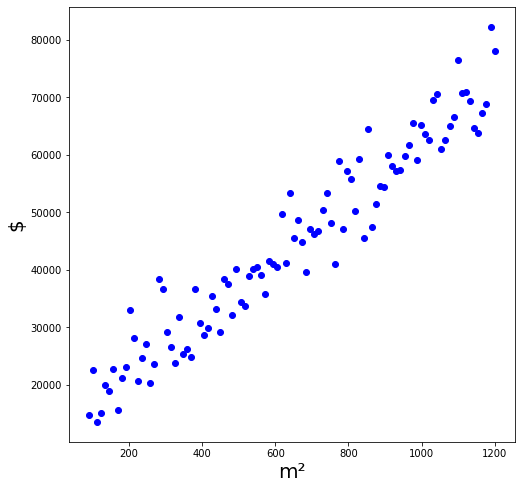

In [37]:
plot_points_regression(X,
                       y,
                       title='Real estate prices prediction',
                       xlabel="m\u00b2",
                       ylabel='$')

### The solution

Given $f:\mathbb{R}^{N\times M} \rightarrow \mathbb{R}$ and $\mathbf{A} \in \mathbb{R}^{N\times M}$, we define the gradient of $f$ with respect to $\mathbf{A}$ as:

\begin{equation*}
\nabla_{\mathbf{A}}f = \frac{\partial f}{\partial \mathbf{A}} =  \begin{bmatrix}
\frac{\partial f}{\partial \mathbf{A}_{1,1}} & \dots & \frac{\partial f}{\partial \mathbf{A}_{1,m}} \\
\vdots &  \ddots & \vdots \\
\frac{\partial f}{\partial \mathbf{A}_{n,1}} &  \dots & \frac{\partial f}{\partial \mathbf{A}_{n,m}}
\end{bmatrix}
\end{equation*}

Let $\mathbf{X} \in \mathbb{R}^{N\times (1+d)}$ be a matrix (sometimes also called the *design matrix*) whose rows are the extended observations of the dataset and let $\mathbf{y} \in \mathbb{R}^{N}$ be the vector consisting of all values $y^{(i)}$ (i.e., $\mathbf{X}^{(i,:)} = \mathbf{\tilde{x}}^{(i)}$ and $\mathbf{y}^{(i)} = y^{(i)}$). It can be verified that: 

\begin{equation}
J(\mathbf{w}) = \frac{1}{N}(\mathbf{X}\mathbf{w} - \mathbf{y})^{T}(\mathbf{X}\mathbf{w} - \mathbf{y})
\end{equation}

Using basic matrix derivative concepts we can compute the gradient of $J(\mathbf{w})$ with respect to $\mathbf{w}$:

\begin{equation}
\nabla_{\mathbf{w}}J(\mathbf{w}) = \frac{2}{N} (\mathbf{X}^{T}\mathbf{X}\mathbf{w} -\mathbf{X}^{T}\mathbf{y})   
\end{equation}

Thus, when $\nabla_{\mathbf{w}}J(\mathbf{w}) = 0$ we have 

\begin{equation}
\mathbf{X}^{T}\mathbf{X}\mathbf{w} = \mathbf{X}^{T}\mathbf{y}
\end{equation}

Hence,

\begin{equation}
\mathbf{w} = (\mathbf{X}^{T}\mathbf{X})^{-1}\mathbf{X}^{T}\mathbf{y}
\end{equation}

Note that this solution has a high computational cost. As the number of variables (*features*) increases, the cost for matrix inversion becomes prohibitive. See  [this text](https://sgfin.github.io/files/notes/CS229_Lecture_Notes.pdf) for more details.

## NumPy
Quoted from [NumPy documentation](https://numpy.org/doc/stable/): "NumPy is the fundamental package for scientific computing in Python. It is a Python library that provides a multidimensional array object, various derived objects (such as masked arrays and matrices), and an assortment of routines for fast operations on arrays, including mathematical, logical, shape manipulation, sorting, selecting, I/O, discrete Fourier transforms, basic linear algebra, basic statistical operations, random simulation and much more."

A quick introduction to this library can be found [here](http://cs231n.github.io/python-numpy-tutorial/). Particularly useful for this EP (and this course) are the "array math" related tools.

# <mark>Exercise 1</mark>
The objective of this exercise is to apply the solution just described on the dataset above created.

Using only **NumPy**, complete the two functions below. Recall that $\mathbf{X} \in \mathbb{R}^{N\times d}$; thus you will need to add a component of value 1 to each of  the observations in $\mathbf{X}$ before performing the computation described above.

NOTE: Although the dataset above has data of dimension $d=1$, your code must be generic (it should work for $d\geq1$)

## <mark>1.1. Weight computation function</mark>

In [38]:
def normal_equation_weights(X, y):
    """
    Calculates the weights of a linear function using the normal equation method.
    You should add into X a new column with 1s.

    :param X: design matrix
    :type X: np.ndarray(shape=(N, d))
    :param y: regression targets
    :type y: np.ndarray(shape=(N, 1))
    :return: weight vector
    :rtype: np.ndarray(shape=(1+d, 1))
    """
    
    # START OF YOUR CODE:
    N = X.shape[0]
    X = np.c_[np.ones(N),X]
    X_t = X.transpose()
    w = np.matmul(np.matmul(np.linalg.inv( np.matmul(X_t,X)) , X_t) , y)
    return w
    # END OF YOUR CODE
    

\begin{equation}
\mathbf{w} = (\mathbf{X}^{T}\mathbf{X})^{-1}\mathbf{X}^{T}\mathbf{y}
\end{equation}

In [39]:
# test of function normal_equation_weights()

w = 0  # this is not necessary
w = normal_equation_weights(X, y)
print("Estimated w =\n", w)

Estimated w =
 [[12165.14670257]
 [   50.42103693]]


## <mark>1.2. Prediction function</mark>

In [40]:
def normal_equation_prediction(X, w):
    """
    Calculates the prediction over a set of observations X using the linear function
    characterized by the weight vector w.
    You should add into X a new column with 1s.

    :param X: design matrix
    :type X: np.ndarray(shape=(N, d))
    :param w: weight vector
    :type w: np.ndarray(shape=(1+d, 1))
    :param y: regression prediction
    :type y: np.ndarray(shape=(N, 1))
    """
    
    # START OF YOUR CODE:
    N = X.shape[0] #Number of lines in X
    w_t = w.transpose()
    X_til = np.c_[np.ones(N),X]
    y = np.full((N,1),None)
    for i in range(N):
        y[i] = np.matmul(w_t,X_til[i])
        
    return y
    # END OF YOUR CODE


## <mark>1.3. Coefficient of determination</mark>
We can use the [$R^2$](https://pt.wikipedia.org/wiki/R%C2%B2) metric (Coefficient of determination) to evaluate how well the linear model fits the data.

**Which $𝑅^2$ value would you expect to observe ?**

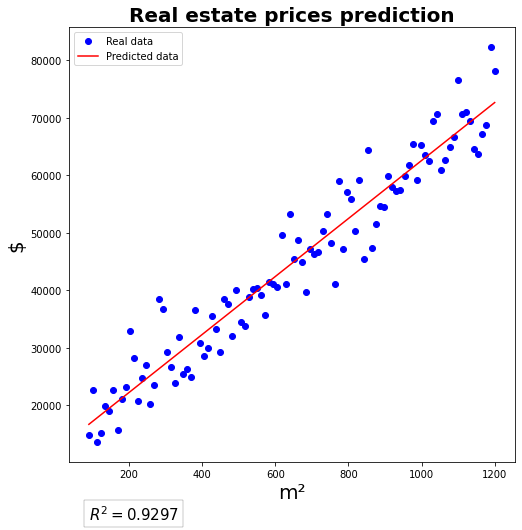

In [41]:
from sklearn.metrics import r2_score

# test of function normal_equation_prediction()
prediction = normal_equation_prediction(X, w)

# compute the R2 score using the r2_score function from sklearn
# Replace 0 with an appropriate call of the function

# START OF YOUR CODE:
r_2 = r2_score(y,prediction)
#We expect a R2 score close to 1, since most points seem to be reasonably aligned with the fitted line.
# END OF YOUR CODE

plot_points_regression(X,
                       y,
                       title='Real estate prices prediction',
                       xlabel="m\u00b2",
                       ylabel='$',
                       prediction=prediction,
                       legend=True,
                       r_squared=r_2)

## Additional tests

Let us compute a prediction for $x=650$


In [42]:
# Let us use the prediction function
x = np.asarray([650]).reshape(1,1)
prediction = normal_equation_prediction(x, w)
print("Area = %.2f  Predicted price = %.4f" %(x[0], prediction))

Area = 650.00  Predicted price = 44938.8207


## <mark>1.4. Processing time</mark>

Experiment with different number of samples $N$ and observe how processing time varies.

Be careful not to use a too large value; it may make jupyter freeze ...

In [43]:
# Add other values for N
# START OF YOUR CODE:
N = [100,200,1000,10000,100000,1000000] 
# END OF YOUR CODE

for i in N:
    X, y = get_housing_prices_data(N=i)
    init = time.time()
    w = normal_equation_weights(X, y)
    prediction = normal_equation_prediction(X,w)
    init = time.time() - init
    
    print("\nExecution time = {:.8f}(s)\n".format(init))


X shape = (100, 1)
y shape = (100, 1)

X: mean 645.0, sdt 323.65, max 1200.00, min 90.00
y: mean 44187.79, sdt 16572.42, max 74212.94, min 9069.57

Execution time = 0.00096869(s)


X shape = (200, 1)
y shape = (200, 1)

X: mean 645.0, sdt 322.04, max 1200.00, min 90.00
y: mean 44140.62, sdt 16257.79, max 74390.26, min 8995.28

Execution time = 0.00039887(s)


X shape = (1000, 1)
y shape = (1000, 1)

X: mean 645.0, sdt 320.75, max 1200.00, min 90.00
y: mean 44377.43, sdt 16468.51, max 80187.49, min 10559.76

Execution time = 0.00373745(s)


X shape = (10000, 1)
y shape = (10000, 1)

X: mean 645.0000610351562, sdt 320.46, max 1200.00, min 90.00
y: mean 44300.23, sdt 16488.30, max 81852.27, min 5512.02

Execution time = 0.03452063(s)


X shape = (100000, 1)
y shape = (100000, 1)

X: mean 645.0000610351562, sdt 320.43, max 1200.00, min 90.00
y: mean 44264.44, sdt 16528.30, max 86693.16, min 3422.27

Execution time = 0.34051132(s)


X shape = (1000000, 1)
y shape = (1000000, 1)

X: mean 64

# <mark>Exercise 2</mark>

In this exercise, the goal is to play with the data we have collected in our first class. Download the data file from [here](https://edisciplinas.usp.br/draftfile.php/5062945/user/draft/622707057/dataMAC0460_5832.csv) (or directly from e-disciplinas, seção Tarefas). 
We will also try to explore cases where $d>1$.

Note that there might be some invalid data entries. It is up to you how you will handle those data. Note that if you decide to do some pre-processing of the dataset, it should be done in this notebook (you are not allowed to edit the CSV datasheet). Feel free to added new cells if that helps to better organize your code.


## Reading the dataset

In [44]:
import pandas as pd

# load the dataset
df = pd.read_csv('dataMAC0460_5832.csv')
df.head()

,Sex,Age,Height,Weight,Shoe number,Trouser number
0,Female,53,154,59,36,40
1,Male,23,170,56,40,38
2,Female,23,167,63,37,40
3,Male,21,178,78,40,40
4,Female,25,153,58,36,38


In [45]:
df.describe()

,Age,Height,Weight,Shoe number
count,202.000000,202.000000,202.000000,202.000000
mean,28.133663,171.084158,72.004950,39.777228
std,11.934604,12.808496,17.093392,2.857281
min,3.000000,65.000000,15.000000,24.000000
25%,21.000000,166.250000,61.000000,38.000000
50%,23.000000,172.500000,70.000000,40.000000
75%,29.750000,178.000000,81.750000,42.000000
max,67.000000,194.000000,159.000000,46.000000


### Let's establish 'Weight' as the target variable

In [46]:
# Our target variable is the Weight
y = df['Weight']
y

0      59
1      56
2      63
3      78
4      58
       ..
197    57
198    68
199    65
200    51
201    62
Name: Weight, Length: 202, dtype: int64

## <mark>2.1. One feature ($d=1$)</mark>

We will use 'Height' as the input feature and predict the weight

In [47]:
feature_cols = ['Height']
X = df.loc[:, feature_cols]
X.shape

(202, 1)

Write the code for computing the following
- compute the regression weights using $\mathbf{X}$ and $\mathbf{y}$
- compute the prediction
- compute the $R^2$ value
- plot the regression graph (use appropriate values for the parameters of function <tt>plot_points_regression()</tt>)

In [48]:
# START OF YOUR CODE:
weights_1 = normal_equation_weights(X,y)
y_pred_1 = normal_equation_prediction(X,weights_1)
r2_score_1 = r2_score(y,y_pred_1)
r2_score_1
# END OF YOUR CODE


0.06701139583266913

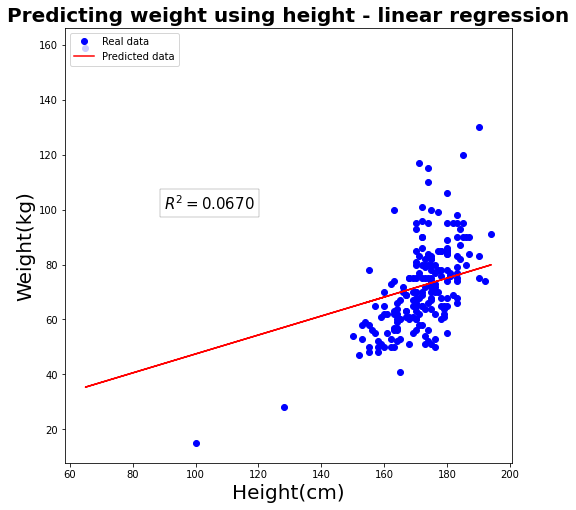

In [49]:
X_ = np.array(X)
y_ = np.array(y)
plot_points_regression(X_,
                       y_,
                       title = 'Predicting weight using height - linear regression',
                       xlabel = 'Height(cm)',
                       ylabel = 'Weight(kg)',
                       prediction = y_pred_1, 
                       legend = True,
                       r_squared = r2_score_1)

## <mark>2.2 - Two input features ($d=2$)</mark>

Now repeat the exercise using as input the features 'Height' and 'Shoe number'

- compute the regression weights using $\mathbf{X}$ and $\mathbf{y}$
- compute the prediction
- compute and print the $R^2$ value

Note that our plotting function can not be used for this dataset. Here there is no need to do the plotting.

In [50]:
# START OF YOUR CODE:
feature_cols = ['Height','Shoe number']
X = df.loc[:, feature_cols]
weights_2 = normal_equation_weights(X,y)
y_pred_2 = normal_equation_prediction(X,weights_2)
r2_score_2 = r2_score(y,y_pred_2)
r2_score_2
# END OF YOUR CODE


0.36989613854051295

## 2.3 - <mark>Three input features ($d=3$)</mark>

Now try with three features. There is no need to do plotting here.
- compute the regression weights using $\mathbf{X}$ and $\mathbf{y}$
- compute the prediction
- compute and print the $R^2$ value

In [51]:
# START OF YOUR CODE:

#transforming 'Sex' into a binary variable, 0 = Female, 1 = Male
df2 = pd.concat([df,pd.get_dummies(df['Sex']).drop('Female',axis = 1)], axis = 1)
df2 = df2.drop('Sex',axis = 1).rename(columns = {'Male':'Sex','Trouser number':'Trouser_number'})
#################################################################

#Dropping categorical values from feature 'Trouser_number'
df2['Trouser_number'] = pd.to_numeric(df2['Trouser_number'],errors = 'coerce')
df2 = df2.dropna()
#Dropping height = 65cm line
df2 = df2.drop(df2[df2['Height'] == 65].index)
#Since we dropped some lines, we need to redefine who is our target
y = df2['Weight']
#################################################################

feature_cols = ['Trouser_number','Shoe number','Height']
X = df2.loc[:, feature_cols]
weights_3 = normal_equation_weights(X,y)
y_pred_3 = normal_equation_prediction(X,weights_3)
r2_score_3 = r2_score(y,y_pred_3)
r2_score_3
#END OF YOUR CODE


0.6315907272870619

# 3. <mark>Your comments</mark>

Write any comments about your implementation or about the results you observed.

===> A variável 'Sex' foi transformada de variável categórica para variável numérica binária,
para que pudesse ser colocada como input nos modelos. 0 representa 'Female', 1 representa 'Male'.


===> Observando o output abaixo(dos value_counts de cada feature), vemos que a variável 'Trouser number' possui inputs não numéricos, como 'S', 'M'
e 'G'. Como os dados do dataset foram coletados de alunos da matéria MAC0460, é possível que existam alunos internacionais. Então por exemplo o input 'M', no Brasil isso corresponde a uma calça de tamanho 40, já nos EUA o tamanho é 48-50 (1).  Assim, esses inputs categóricos não podem ser confiavelmente convertidos para seus valores correspondentes numéricos, já que não sabemos o país de origem que cada pessoa que respondeu a pesquisa.
Se fosse o caso que o questionário deixasse claro que o input deveria ser o tamanho de calças no padrão de medida do Brasil, uma opção seria usar a tabela(1) para converter estes inputs categóricos em seus correspondentes valores numéricos.
Como eu não tenho a informação de que o questionário incluiu tal ressalva, optou-se pela opção mais segura que é dropar as linhas que continham valores categóricos da feature 'Trouser number'.
Uma consideração importante também é que são apenas 3 linhas que possuem valores categóricos, o que faz a opção de excluí-las ter um impacto desprezível no tamanho do dataset.

===>Olhando para o histograma de cada feature, vemos a existência de alguns valores incomuns para algumas features:
* Uma pessoa com altura = 65cm e idade = 26 anos. Considerando que a altura média de uma pessoa com nanismo é em torno de 122cm (2), e a menor pessoa  da história tem altura de 54.6 cm (3), e levando em consideração o tamanho de sapato de 36 (valor grande para uma pessoa de estatura baixa), é razoável supor que tenha sido um erro de escrita, e o valor coletado da altura da pessoa não corresponda ao valor real. Portanto, essa linha foi retirada da análise.

* A existência de pessoas de 3 e 8 anos nos dados, mas foi dito em aula pela professora que os dados podem ter sido coletados não apenas de alunos mas também de vizinhos, então essas idades baixas são possíveis.

* Um tamanho de calça = 12, de uma pessoa de idade = 8 anos. Aparentemente existe calça desse tamanho para venda (4), então esse valor é crível.

Nas outras features, não há outliers que se diferenciem o suficiente para crer que tenham sido erros na coleta dos dados.


===> No exercício 2.3, como o modelo é linear, um razoável chute inicial é selecionar as features baseadas na correlação com a target. Em uma exploração mais profunda, uma opção seria experimentar usar outras features.


(1) https://br.privalia.com/microsites/sizeguide

(2) https://www.mayoclinic.org/diseases-conditions/dwarfism/symptoms-causes/syc-
20371969#:~:text=Overview,4%20feet%20(122%20cm).

(3) https://en.wikipedia.org/wiki/Chandra_Bahadur_Dangi

(4) https://produto.mercadolivre.com.br/MLB-1207992033-kit-3-calca-jeans-masculina-infantil-meninos-1-ao-16-anos-_JM

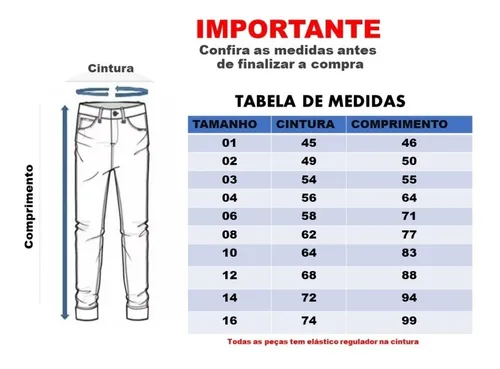


array([[<AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'Height'}>],
       [<AxesSubplot:title={'center':'Weight'}>,
        <AxesSubplot:title={'center':'Shoe number'}>],
       [<AxesSubplot:title={'center':'Trouser_number'}>,
        <AxesSubplot:title={'center':'Sex'}>]], dtype=object)

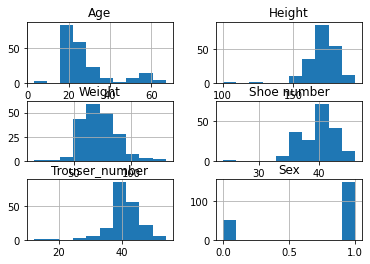

In [52]:
df2.hist()

In [53]:
df[df['Shoe number'] < 35]
#Normal

,Sex,Age,Height,Weight,Shoe number,Trouser number
14,Female,27,152,47,34,34
24,Female,3,100,15,24,20
60,Female,21,155,48,34,34
93,Male,8,128,28,33,12
148,Female,23,159,51,34,31
153,Female,21,159,61,34,38
162,Female,58,153,53,34,32


In [54]:
df[df['Height'] < 150]
#Altura estranha na linha 133.

,Sex,Age,Height,Weight,Shoe number,Trouser number
24,Female,3,100,15,24,20
93,Male,8,128,28,33,12
133,Female,26,65,159,36,36


In [55]:
df2[df2['Trouser_number'] < 35]
#Tamanho de calça = 12 incomum, mas parece que existe esse tamanho para criança

,Age,Height,Weight,Shoe number,Trouser_number,Sex
14,27,152,47,34,34.0,0
24,3,100,15,24,20.0,0
60,21,155,48,34,34.0,0
82,20,172,90,40,34.0,1
93,8,128,28,33,12.0,1
103,29,184,82,44,32.0,1
119,21,168,61,39,30.0,1
148,23,159,51,34,31.0,0
151,27,163,50,39,31.0,1
158,30,180,85,41,34.0,1


In [56]:
df[df['Age'] < 18]
#Pessoas de 3 e 8 anos, mas foi dito em aula pela professora que os dados podem ter sido coletados
#não apenas de alunos mas também de vizinhos, então essas idades baixas são possíveis.

,Sex,Age,Height,Weight,Shoe number,Trouser number
24,Female,3,100,15,24,20
93,Male,8,128,28,33,12
200,Male,17,168,51,38,36


In [57]:
df[df['Weight'] < 50]
#Normal

,Sex,Age,Height,Weight,Shoe number,Trouser number
14,Female,27,152,47,34,34
24,Female,3,100,15,24,20
31,Female,19,158,48,36,36
60,Female,21,155,48,34,34
93,Male,8,128,28,33,12
196,Female,20,165,41,36,26


In [58]:
#Value_counts de cada feature do dataset original
for column in df.columns:
    print(df[column].sort_index().value_counts())

Male      149
Female     53
Name: Sex, dtype: int64
21    27
20    24
22    23
23    16
25    12
26    12
27     9
30     9
19     8
24     6
29     6
58     6
31     5
28     4
32     3
35     3
59     2
57     2
56     2
49     2
52     2
62     2
40     1
41     1
67     1
60     1
36     1
33     1
54     1
66     1
53     1
8      1
48     1
45     1
18     1
3      1
37     1
55     1
17     1
Name: Age, dtype: int64
175    16
170    16
180    13
172    12
183    10
174    10
173     8
176     8
164     8
178     7
163     7
169     6
171     6
177     5
165     5
168     5
167     5
160     4
155     4
179     4
185     3
158     3
162     3
181     3
190     3
184     3
161     2
157     2
159     2
182     2
187     2
186     2
166     2
153     2
192     1
100     1
194     1
128     1
152     1
150     1
156     1
65      1
154     1
Name: Height, dtype: int64
75     10
65     10
70      9
60      7
62      7
80      7
95      6
90      6
85      6
68      6
50      6
78    

In [59]:
#Correlação entre as features e o target
df2.corr()['Weight'].sort_values(ascending = False)

Weight            1.000000
Trouser_number    0.737412
Shoe number       0.640313
Height            0.622221
Sex               0.336456
Age               0.104954
Name: Weight, dtype: float64

In [60]:
df2.corr()

,Age,Height,Weight,Shoe number,Trouser_number,Sex
Age,1.000000,-0.058091,0.104954,-0.090726,0.256962,-0.237257
Height,-0.058091,1.000000,0.622221,0.862358,0.530983,0.547272
Weight,0.104954,0.622221,1.000000,0.640313,0.737412,0.336456
Shoe number,-0.090726,0.862358,0.640313,1.000000,0.538150,0.716330
Trouser_number,0.256962,0.530983,0.737412,0.538150,1.000000,0.156043
Sex,-0.237257,0.547272,0.336456,0.716330,0.156043,1.000000
